In [1]:
import numpy as np
import cv2
import os
import math
import matplotlib.pyplot as plt

In [2]:
def itgboxsum(itgImg, h0, w0, h1, w1):
    A = itgImg[h0, w0]
    B = itgImg[h0, w1]
    C = itgImg[h1, w0]
    D = itgImg[h1, w1]
    return D - C - B + A


def create_HARR(h, w):
    '''
    Create Harr-like filters, only return the shape discription
    '''
    kernel_shapes = []
    # horizontal:
    for i in range(1, int(w/2)+1):
        h_win, w_win = 1, i
        h_shift, w_shift = 0, i
        kernel_shapes.append(((h_win, w_win), (h_shift, w_shift)))
    # vertical:
    for j in range(1, int(h/2)+1):
        h_win, w_win = j, 2
        h_shift, w_shift = j, 0
        kernel_shapes.append(((h_win, w_win), (h_shift, w_shift)))        
    return kernel_shapes


def make_feature(img):
    '''
    Construct features by a series Harr-like filters
    '''
    h, w = img.shape
    itgImg = cv2.integral(img)
    filters = create_HARR(h, w)
    features = []
    for (h_win, w_win), (h_shift, w_shift) in filters:
        filter_h, filter_w = h_win + h_shift, w_win + w_shift
        for r in range(h - filter_h + 1):
            for c in range(w - filter_w + 1):
                hp0, wp0, hp1, wp1 = r, c, r + h_win, c + w_win
                s_pos = itgboxsum(itgImg, hp0, wp0, hp1, wp1)
                hn0, wn0, hn1, wn1 = r+h_shift, c+w_shift, r + filter_h, c + filter_w 
                s_neg = itgboxsum(itgImg, hn0, wn0, hn1, wn1)
                features.append(s_pos-s_neg)
    return np.array(features)

In [3]:
def weakClassifer(feature, weights, labels, nPos, nNeg):
    '''
    Training a weak classifier
    '''
    weights = weights / np.sum(weights)
    idx = np.argsort(feature, axis=1)
    
    sorted_feature = np.zeros_like(feature)
    sorted_weights = np.zeros_like(feature).astype(np.float64)
    sorted_label = np.zeros_like(feature)
    for i in range(feature.shape[0]):
        sorted_feature[i] = feature[i][idx[i]].copy()
        sorted_weights[i] = weights[idx[i]].copy()
        sorted_label[i] = labels[idx[i]].copy()
        
    # compute error for all features parallelly
    T_pos = np.sum(weights[np.where(labels == 1)])
    T_neg = np.sum(weights[np.where(labels == 0)])
    S_pos = np.cumsum(sorted_weights * sorted_label, axis=1)
    S_neg = np.cumsum(sorted_weights, axis=1) - S_pos
    e0 = S_pos + T_neg - S_neg
    e1 = S_neg + T_pos - S_pos
    bestErr = np.inf
    best_idx_feature = 0
    # print(np.sum(sorted_label), np.sum(S_pos), np.sum(sorted_weights))
    for i in range(feature.shape[0]):
        minE = np.minimum(e0[i], e1[i])
        idx_minE = np.argmin(minE)

        if e0[i, idx_minE] <= e1[i, idx_minE]:
            p = 1
            prediction = (feature[i] >= sorted_feature[i, idx_minE])
            prediction = prediction.astype(int)
            clsfr = [i, sorted_feature[i, idx_minE], p, e0[i, idx_minE]]
        else:
            p = -1
            prediction = (feature[i] < sorted_feature[i, idx_minE])
            prediction = prediction.astype(int)
            clsfr = [i, sorted_feature[i, idx_minE], p, e1[i, idx_minE]]
        
        if minE[idx_minE] < bestErr:
            classifier = clsfr
            final_prediction = prediction
            bestErr = minE[idx_minE]

    return classifier, final_prediction 

In [4]:
def strongClassifer(train_pos, train_neg):
    '''
    Construct a strong classifier by aggregating multiple weak ones
    '''
    nPos = train_pos.shape[1]
    nNeg = train_neg.shape[1]
    feature = np.concatenate((train_pos, train_neg), axis=1)
    weights = np.array([0.5/nPos]*nPos + [0.5/nNeg]*nNeg)
    labels = np.array([1]*nPos + [0]*nNeg)

    alphas = []
    prediction_list = []
    weak_clfrs = []
    for i in range(50):
        # Run weak classifier and get its result
        clfr, pred = weakClassifer(feature, weights, labels, nPos, nNeg)
        weak_clfrs.append(clfr)
        beta = (clfr[3]+1e-5) / (1-clfr[3]) # prevent the beta=0
        alpha = np.log(1 / beta)
        
        weights = weights * (beta ** (1 - np.abs(labels-pred)))

        alphas.append(alpha)
        prediction_list.append(pred)

        alpha_array = np.array([alphas]).T
        feature_array = np.array(prediction_list).T
        sf = np.dot(feature_array, alpha_array)
        
        th = np.min(sf[:nPos])
        
        Cx = np.zeros(sf.shape)
        # Assign labels and measure the performance
        Cx[sf >= th] = 1
        fpr = np.sum(Cx[nPos:])/nNeg
        # print('      ', beta, np.sum(Cx[nPos:]))
        tpr = np.sum(Cx[:nPos])/nPos    

        tnr = 1 - fpr   
        fnr = 1 - tpr

        print('step: {}: FNR: {}, FPR: {}, FP: {}'.format(i, fnr, np.sum(Cx[nPos:])/1758, np.sum(Cx[nPos:])))
        if tpr >= 1 and fpr <= 0.3:
            break
    cascade_log = {'weak_clfrs':weak_clfrs, 'alphas':alpha_array, 'tpr': tpr, 'fpr':np.sum(Cx[nPos:])/1758, 'fnr':fnr, 'tnr':tnr}
    neg_samples_pred = Cx[nPos:]
    neg_idx = np.where(neg_samples_pred ==1)[0]
    new_train_neg = train_neg[:, neg_idx].copy()
    return cascade_log, new_train_neg

In [5]:
def cascade_classify(cascade_log, data_pos, data_neg):
    '''
    Use the cascaded strong classifiers to classify the testing samples
    '''
    nPos = data_pos.shape[1]
    nNeg = data_neg.shape[1]
    feature = np.concatenate((data_pos, data_neg), axis=1)
    pred_list = []
    # for each stage, get the prediction and collect them from every stage
    for classifer in cascade_log:
        weak_pred = []
        alpha_array = classifer['alphas']
        weak_classifers = classifer['weak_clfrs']
        # for the weak classifiers in the strong classifier
        for cid in range(len(weak_classifers)):
            f_idx = weak_classifers[cid][0]
            th = weak_classifers[cid][1]
            p = weak_classifers[cid][2]
            current_feature = feature[f_idx]
            if p == 1:
                classifResult = np.array(current_feature >= th).astype(int)
            else:
                classifResult = np.array(current_feature < th).astype(int)

            weak_pred.append(classifResult)
        wp_array = np.array(weak_pred).T
        agg_pred = np.dot(wp_array, alpha_array)
        threshold = np.sum(alpha_array) * 0.5
        Cx = np.zeros((agg_pred.shape[0], 1))
        Cx[agg_pred >= threshold] = 1
        pred_list.append(Cx)
    return pred_list

In [6]:
train_path = '/home/xingguang/Documents/ECE661/hw11/DB2/train'
test_path = '/home/xingguang/Documents/ECE661/hw11/DB2/test'
train_pos = []
train_pos_dir = os.path.join(train_path, 'positive')
for path in os.listdir(train_pos_dir):
    img_path = os.path.join(train_pos_dir, path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    train_pos.append(make_feature(img))
train_pos = np.vstack(train_pos).T
    
train_neg = []
train_neg_dir = os.path.join(train_path, 'negative')
for path in os.listdir(train_neg_dir):
    img_path = os.path.join(train_neg_dir, path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    train_neg.append(make_feature(img))
train_neg = np.vstack(train_neg).T
    
test_pos = []
test_pos_dir = os.path.join(test_path, 'positive')
for path in os.listdir(test_pos_dir):
    img_path = os.path.join(test_pos_dir, path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    test_pos.append(make_feature(img))
test_pos = np.vstack(test_pos).T

test_neg = []
test_neg_dir = os.path.join(test_path, 'negative')
for path in os.listdir(test_neg_dir):
    img_path = os.path.join(test_neg_dir, path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    test_neg.append(make_feature(img))
test_neg = np.vstack(test_neg).T

In [7]:
data_pos = train_pos.copy()
data_neg = train_neg.copy()
results = []
train_FN = []
train_FP = []
# build cascaded classifiers using at most 10 stages
for i in range(10):
    result_log, data_neg = strongClassifer(data_pos, data_neg)
    results.append(result_log)
    print('cascade {}, fnr: {}, fpr: {}'.format(i, result_log['fnr'], result_log['fpr']))
    train_FN.append(result_log['fnr'])
    train_FP.append(result_log['fpr'])
    if data_neg.shape[1] == 0:
        break

step: 0: FNR: 0.0, FPR: 1.0, FP: 1758.0
step: 1: FNR: 0.0, FPR: 1.0, FP: 1758.0
step: 2: FNR: 0.0, FPR: 1.0, FP: 1758.0
step: 3: FNR: 0.0, FPR: 1.0, FP: 1758.0
step: 4: FNR: 0.0, FPR: 0.6689419795221843, FP: 1176.0
step: 5: FNR: 0.0, FPR: 0.5523321956769056, FP: 971.0
step: 6: FNR: 0.0, FPR: 0.59613196814562, FP: 1048.0
step: 7: FNR: 0.0, FPR: 0.5142207053469852, FP: 904.0
step: 8: FNR: 0.0, FPR: 0.4112627986348123, FP: 723.0
step: 9: FNR: 0.0, FPR: 0.550056882821388, FP: 967.0
step: 10: FNR: 0.0, FPR: 0.40386803185437997, FP: 710.0
step: 11: FNR: 0.0, FPR: 0.431740614334471, FP: 759.0
step: 12: FNR: 0.0, FPR: 0.39419795221843, FP: 693.0
step: 13: FNR: 0.0, FPR: 0.41751990898748575, FP: 734.0
step: 14: FNR: 0.0, FPR: 0.3236632536973834, FP: 569.0
step: 15: FNR: 0.0, FPR: 0.2923777019340159, FP: 514.0
cascade 0, fnr: 0.0, fpr: 0.2923777019340159
step: 0: FNR: 0.0, FPR: 0.2923777019340159, FP: 514.0
step: 1: FNR: 0.0, FPR: 0.2923777019340159, FP: 514.0
step: 2: FNR: 0.0, FPR: 0.292377701

In [17]:
# test the cascaded classifier and collect results
result = cascade_classify(results, test_pos, test_neg)
test_FP = []
test_FN = []
ntpos = test_pos.shape[1]
ntneg = test_neg.shape[1]
for i in range(len(results)):
    if i == 0:
        f = result[0]
    else:    
        f = np.concatenate(result[:i+1], axis=1)
    ff = np.sum(f, axis=1)
    pred = np.zeros(ff.shape)
    pred[ff == i+1]=1
    test_FP.append(np.sum(pred[ntpos:])/ntneg)
    test_FN.append(1 - np.sum(pred[:ntpos])/ntpos)
print(test_FP)
print(test_FN)

[0.08863636363636364, 0.01818181818181818, 0.006818181818181818, 0.006818181818181818, 0.006818181818181818, 0.006818181818181818]
[0.1179775280898876, 0.1741573033707865, 0.2415730337078652, 0.2921348314606742, 0.3314606741573034, 0.3370786516853933]


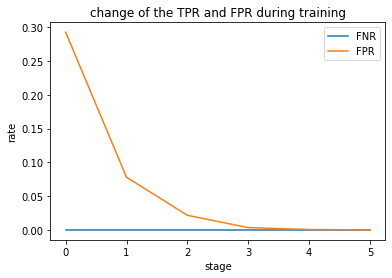

In [9]:
steps = [i for i in range(len(train_FN))]
plt.plot(train_FN, label='FNR')
plt.plot(train_FP, label = 'FPR')
plt.xlabel('stage')
plt.ylabel('rate')
plt.title('change of the TPR and FPR during training')
plt.legend()
plt.show()

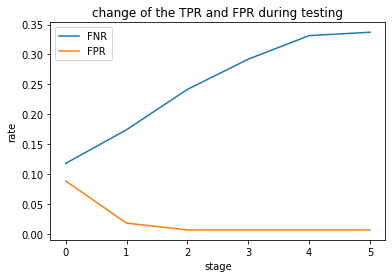

In [18]:
steps = [i+1 for i in range(len(test_FP))]
plt.plot(test_FN, label='FNR')
plt.plot(test_FP, label = 'FPR')
plt.xlabel('stage')
plt.ylabel('rate')
plt.title('change of the TPR and FPR during testing')
plt.legend()
plt.show()